## TB Model Development

In this notebook, we will develop several models that will predict the incurrence of TB using variables or features. This is just an estimate, but should give us an objective idea of how much the incurrence of TB is.

We know that some of the good predictors of Incurrence of TB could be:
<ul>
    
  <li>Population</li>
    <li>Income Group/Class</li>
    <li>Location/region</li>
    <li>HIV</li>
</ul>

We will develop a model using these variables as the predictor variables.

By developing a model, it will help us understand the exact relationship between different variables and how these variables are used to predict the incurrence of TB

Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load data and store in dataframe all_tb:

In [23]:
all_tb = pd.read_csv('https://raw.githubusercontent.com/waithiegeni/python_analysis/master/TB_burden_countries_2019-01-11.csv', encoding = 'utf-8')
all_tb.shape

(3850, 47)

Our data for income group is in a seperate table, we will therefore need to load it and merge it to our TB data.

In [6]:
gdp = pd.read_csv('~/Downloads/Income group to TB..csv', encoding = 'utf-8')
gdp.head(1)

,country,iso3,e_inc_num,e_pop_num,IncomeGroup
0,Afghanistan,AFG,38000,20093756,Low income


In [7]:
#select required columns 
all_tb = all_tb [['country', 'g_whoregion', 'e_inc_num','iso3', 'e_pop_num' ,'e_inc_tbhiv_num', ]]
all_tb.head(1)

,country,g_whoregion,e_inc_num,iso3,e_pop_num,e_inc_tbhiv_num
0,Afghanistan,EMR,38000,AFG,20093756,110.0


In [8]:
#merge both datasets
merged_data = pd.merge(all_tb,gdp, on = ['iso3'])
merged_data.head(2)

,country_x,g_whoregion,e_inc_num_x,iso3,e_pop_num_x,e_inc_tbhiv_num,country_y,e_inc_num_y,e_pop_num_y,IncomeGroup
0,Afghanistan,EMR,38000,AFG,20093756,110.0,Afghanistan,38000,20093756,Low income
1,Afghanistan,EMR,40000,AFG,20966463,100.0,Afghanistan,38000,20093756,Low income


In [9]:
all_tb.shape , merged_data.shape

((3850, 6), (3719, 10))

We can see that we have lost 131 rows of our data, let's find out which of the rows were not included during the merge

In [10]:
not_included = pd.merge(all_tb, merged_data, on = ['iso3'], how = "left", indicator = True)

not_included = not_included.loc[not_included["_merge"] == "left_only"]
not_included.shape

(131, 16)

In [11]:
not_included.head()

,country,g_whoregion_x,e_inc_num,iso3,e_pop_num,e_inc_tbhiv_num_x,country_x,g_whoregion_y,e_inc_num_x,e_pop_num_x,e_inc_tbhiv_num_y,country_y,e_inc_num_y,e_pop_num_y,IncomeGroup,_merge
1944,Anguilla,AMR,2,AIA,11070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1945,Anguilla,AMR,3,AIA,11372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1946,Anguilla,AMR,3,AIA,11692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1947,Anguilla,AMR,3,AIA,12021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1948,Anguilla,AMR,3,AIA,12339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


We can see that the data not included were countries not on the gdp data , let's include them back because they have significant data of our response variable and we will later on replace the missing data for the exploratory variables that are necessary.

In [12]:
#rename merged data columns
merged_data.rename(columns = {'country_x': 'country' , 'e_inc_num_x' : 'tb' , 'e_pop_num_x' : 'population', 'g_whoregion' : 'region', 'e_inc_tbhiv_num' : 'hiv'  }, inplace = True)

not_included.rename(columns = {'e_inc_num' : 'tb' , 'e_pop_num' : 'population', 'g_whoregion_x' : 'region'}, inplace = True)

In [13]:
#concatenate
merge = pd.concat([merged_data, not_included], sort = True , ignore_index = True)
merge.shape

(3850, 17)

In [14]:
#select required columns
tb =  merge[['country','region', 'IncomeGroup', 'tb', 'hiv', 'population']]
tb.head(2)

,country,region,IncomeGroup,tb,hiv,population
0,Afghanistan,EMR,Low income,38000,110.0,20093756
1,Afghanistan,EMR,Low income,40000,100.0,20966463


#### Evaluating for Missing Data

In [15]:
#missing values

missing_data = tb.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())

country
False    3850
Name: country, dtype: int64
region
False    3850
Name: region, dtype: int64
IncomeGroup
False    3719
True      131
Name: IncomeGroup, dtype: int64
tb
False    3850
Name: tb, dtype: int64
hiv
False    3513
True      337
Name: hiv, dtype: int64
population
False    3850
Name: population, dtype: int64


Based on the summary above, each column has 3850 rows of data, 2 columns contain missing data:
<ol>
    <li>"IncomeGroup" : 131 missing data</li>
    <li>"hiv" : 337 missing data</li>
   
</ol>

How will we deal with the missing data? We can either drop or replace the data. Whole columns should be dropped only if most entries in the column are empty. In our dataset, none of the columns are empty enough to drop entirely.
We have some freedom in choosing which method to replace data, either by mean or mode;. however, some methods may seem more reasonable than others. We will apply each method to each column:

###### Replace by Frequency:
<ul>
    <li>"IncomeGroup": 131 missing data, replace them with frequency</li>
</ul>

###### Replace by Mean:
<ul>
    <li>"hiv": 337 missing data, replace them with mean</li>

In [16]:
#Calculate the highest frequency of the IncomeGroup:
avg_inc = tb['IncomeGroup'].value_counts().idxmax()
avg_inc

'High income'

In [25]:
#Replace "NaN" by "High Income"  in "IncomeGroup" column
tb['IncomeGroup'].replace('nan', avg_inc, inplace=True)

In [18]:
#Calculate the mean of hiv:
avg_hiv = tb['hiv'].mean(axis=0)
avg_hiv

6543.257614574438

In [19]:
#Replace "NaN" by mean in "hiv" column
tb['hiv'].replace(np.nan, avg_hiv, inplace = True)

counter check to see whether there are any missing values

In [20]:
#missing values
missing_data = tb.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())

country
False    3850
Name: country, dtype: int64
region
False    3850
Name: region, dtype: int64
IncomeGroup
False    3719
True      131
Name: IncomeGroup, dtype: int64
tb
False    3850
Name: tb, dtype: int64
hiv
False    3850
Name: hiv, dtype: int64
population
False    3850
Name: population, dtype: int64


<b>Great!</b> The last step will be to check whether our data is in the correct format

In [21]:
tb.dtypes

country         object
region          object
IncomeGroup     object
tb               int64
hiv            float64
population       int64
dtype: object

#### Let's find the scatterplot of "population" and "Tb"

In order to start understanding the (linear) relationship between an individual variable and TB. We can do this by using "regplot", which plots the scatterplot plus the fitted regression line for the data.

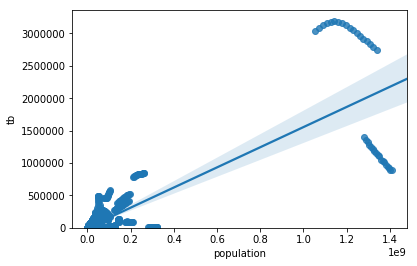

In [104]:
#population as potential predictor variable of tb
import seaborn as sns

sns.regplot(x="population", y="tb", data=tb)
plt.ylim(0,)
plt.show()

In [108]:
#import stats
from scipy import stats

#correlation and p-value
pearson_coef, p_value = stats.pearsonr(tb['population'], tb['tb'])
pearson_coef,p_value

(0.8413953198747588, 0.0)

While theres is a positive direct correlation between these two variables, the p_value = 0.0 , the The plot would make more sense if we grouped our figures by our exploratory variables Region and IncomeGroup

In [96]:
#group by region
tb_grouped = tb.groupby(['region'],as_index=False).mean()
tb_grouped

,region,tb,hiv,population
0,AFR,54912.877844,20004.032335,1.803674e+07
1,AMR,6216.178218,1532.651295,2.056271e+07
2,EMR,31533.972222,304.113636,2.632330e+07
3,EUR,7158.814891,881.173564,1.661279e+07
4,SEA,430985.000000,23065.647959,1.632751e+08
5,WPR,55018.325617,2710.496502,5.008829e+07


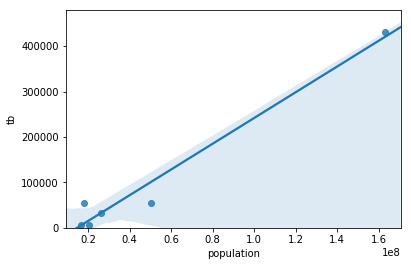

In [97]:
# Population as potential predictor variable of TB
sns.regplot(x="population", y="tb", data=tb_grouped)
plt.ylim(0,)
plt.show()

As the population goes up, TB goes up: this indicates a positive direct correlation between these two variables. Population seems like a pretty good predictor of TB since the regression line is almost a perfect diagonal line.

We can examine the correlation and P-value between Population and TB. It is important to get p_value as well because correlation does not imply causation.

In [111]:
#correlation and p-value
pearson_coef, p_value = stats.pearsonr(tb_grouped['population'], tb_grouped['tb'])
pearson_coef,p_value

(0.983923611549623, 0.00038559792497861654)

#### Conclusion:

Since the p-value is $<$ 0.001, the correlation between Population and Tb is statistically significant, and the linear relationship is extremely strong since 0.98 is close to 1. Therefore, population grouped by region is a good predicator of Tb if not the prefect predicator.

#### Let's find the scatterplot of "hiv" and "Tb"

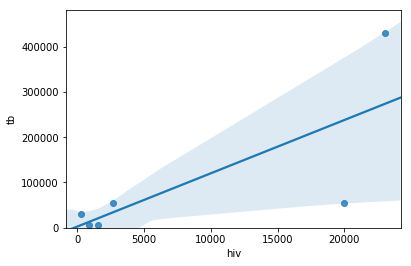

In [112]:
# HIV as a potential predictor variable of TB
sns.regplot(x="hiv", y="tb", data=tb_grouped)
plt.ylim(0,)
plt.show()

In [113]:
#correlation and p-value
pearson_coef, p_value = stats.pearsonr(tb_grouped['hiv'], tb_grouped['tb'])
pearson_coef,p_value

(0.7494901387858297, 0.08627238880879279)

#### Conclusion:

Since the p-value is $<$ 0.1 and $>$ 0.05 there is weak evidence that the correlation between hiv and tb is significant even though the linear relationship is a bit strong (0.749 is close to 1). HIV will not be good predicator of TB

#### Let's find the scatterplot of "population" and "Tb" grouping by IncomeGroup

In [115]:
#grouping
tb_grouped2 = tb.groupby(['IncomeGroup'],as_index=False).mean()
tb_grouped2

,IncomeGroup,tb,hiv,population
0,High income,2524.389490,886.515578,1.611928e+07
1,Low income,44560.299501,10921.745424,1.757557e+07
2,Lower middle income,146270.946731,12374.131522,5.724501e+07
3,Upper middle income,39598.697395,6415.052379,4.395249e+07


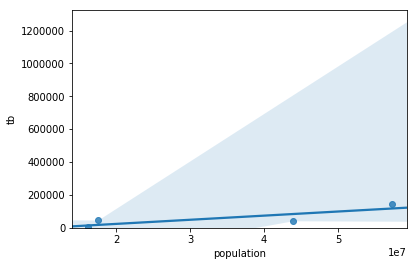

In [116]:
sns.regplot(x="population", y="tb", data=tb_grouped2)
plt.ylim(0,)
plt.show()

In [117]:
#correlation and p-value
pearson_coef, p_value = stats.pearsonr(tb_grouped2['population'], tb_grouped2['tb'])
pearson_coef,p_value

(0.8238693457429606, 0.1761306542570395)

#### Conclusion:

Since the p-value is $>$ 0.1 , there is no evidence that the correlation is significant, though the linear relationship is strong (0.823 close to 1) Population based on Income class is not a good predicator of Tb.

Now that we know that population and region have a stong correlation to TB we should expect ANOVA to return a sizeable F-test score and a small p-value for region.

### Anova Analysis